## Data collection and loading dataset

We used the following tool to extract all comments from the "worldnews" subreddit and using AI we extracted the first 1000 comments for each of the data ranges we want to analyze that have one of the following keywords: "israel", "idf", "netanyahu"

**Data Ranges:**
- Before - 2023-09-21 / 2023-10-6
- During - 2023-10-7 / 2023-10-10
- After - 2024-04-7 / 2024-04-21

The data ranges vary on time as there were millions of comments the tool extracted making the files too large for certain dates

In [16]:
import pandas as pd

# Load json files as DataFrames for different time ranges
df_before = pd.read_json(r'data\comments_before_oct7.jsonl', lines=True)
df_during = pd.read_json(r'data\comments_during_oct7.jsonl', lines=True)
df_after = pd.read_json(r'data\comments_after_oct7.jsonl', lines=True)

# Concatenate all data into one DataFrame
df = pd.concat([df_before, df_during, df_after], ignore_index=True)

In [17]:
# Basic Exploration of the DataFrame

print("Shape:", df.shape)
print("="*25)
print(f"\n{df.head()}")
print("="*25)
print(f"\n{df.info()}")

Shape: (3000, 72)

                              _meta all_awardings  approved_at_utc  \
0  {'retrieved_2nd_on': 1703275026}            []              NaN   
1  {'retrieved_2nd_on': 1703275262}            []              NaN   
2  {'retrieved_2nd_on': 1703275301}            []              NaN   
3  {'retrieved_2nd_on': 1703275934}            []              NaN   
4  {'retrieved_2nd_on': 1703276762}            []              NaN   

   approved_by  archived  associated_award              author  \
0          NaN     False               NaN          chrisjinna   
1          NaN     False               NaN       ToastedPerson   
2          NaN     False               NaN        bobdob123usa   
3          NaN     False               NaN       FYoCouchEddie   
4          NaN     False               NaN  preemptivePacifist   

  author_flair_background_color  author_flair_css_class author_flair_richtext  \
0                          None                     NaN                    []   
1

## Data Preprocessing

In [18]:
# Leave relevant columns only
df = df[['created', 'body', 'score']]

In [19]:
# Transform created from unix epoch to timestamp

df['created'] = pd.to_datetime(df['created'], unit='s')
df['created']

0      2023-09-22 00:01:57
1      2023-09-22 00:07:52
2      2023-09-22 00:08:53
3      2023-09-22 00:25:11
4      2023-09-22 00:46:38
               ...        
2995   2024-04-07 18:01:27
2996   2024-04-07 18:02:04
2997   2024-04-07 18:03:28
2998   2024-04-07 18:03:30
2999   2024-04-07 18:04:15
Name: created, Length: 3000, dtype: datetime64[ns]

In [20]:
# Create Column to Classify Dates as Before, During, After
start_date = pd.Timestamp('2023-10-07')
end_date = pd.Timestamp('2023-10-21')

df['period'] = df['created'].apply(
    lambda x: 'Before' if x < start_date else
              'During' if start_date <= x <= end_date else
              'After'
)

# Check
df['period'].value_counts()

period
Before    1000
During    1000
After     1000
Name: count, dtype: int64

In [21]:
# Check duplicates
df.duplicated().sum()

np.int64(0)

In [22]:
# Check statistics
df.describe(include='all')

,created,body,score,period
count,3000,3000,3000.000000,3000
unique,NaN,2980,NaN,3
top,NaN,Yeah no…. Israel has had an issue with raping ...,NaN,Before
freq,NaN,4,NaN,1000
mean,2023-12-03 20:42:22.366666752,NaN,27.805667,NaN
min,2023-09-22 00:01:57,NaN,-347.000000,NaN
25%,2023-09-29 16:08:17.500000,NaN,0.000000,NaN
50%,2023-10-07 07:02:58,NaN,4.000000,NaN
75%,2024-04-07 06:36:11,NaN,19.000000,NaN
max,2024-04-07 18:04:15,NaN,3556.000000,NaN


In [23]:
# Convert all body samples to lowercase
df['body'] = df['body'].str.lower()

## Sentiment Analysis

We decided to use an NLP model as its the best fit model to get

### VADER Sentiment Scoring

We use NLTK's SentimentIntensityAnalyzer to get compound sentiment scores of the text.

This model uses a 'bag of words' approach:
1. Stop words are removed
2. Each word is scored and combined to a total score

Is a straightforward model although it has its limitations as it doesn't take into consideration the relationship between words which might limit the accuracy of our sentiment score, this is why we'll use other models to compare sentiment score results.



In [24]:
import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nivya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Instantiate SIA object
sia = SentimentIntensityAnalyzer()

In [26]:
# Run the polarity score on the entire dataset
df['Sentiment_Score'] =  df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])

df.head()

,created,body,score,period,Sentiment_Score
0,2023-09-22 00:01:57,what isn't being occupied right now over there...,-2,Before,-0.3736
1,2023-09-22 00:07:52,"someone needs to grab their sniper, hop on the...",0,Before,-0.1531
2,2023-09-22 00:08:53,> the government of israel is not the same as...,0,Before,0.0000
3,2023-09-22 00:25:11,> israel exploits the holocaust to censor any ...,1,Before,-0.9201
4,2023-09-22 00:46:38,this is not necessarily an extremist view or e...,1,Before,0.3291


#### Correlation between sentiment and upvote score

We see that there's no correlation between the features 'score' which represents the number of upvotes - number of downvotes and 'Sentiment_Score' calculated by the VADER model.

From this information we can infer that there's no bias for or against Israel within the worldnews subreddit

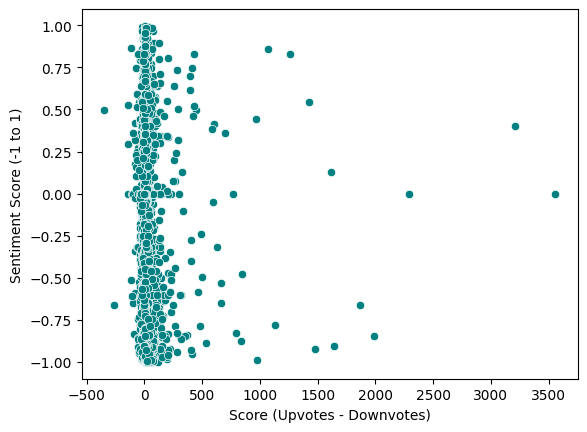

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

df_scores_sentiment = df[~df['score'].isin([0, 1])]

sns.scatterplot(data=df_scores_sentiment, x='score', y='Sentiment_Score', color='teal')
plt.xlabel('Score (Upvotes - Downvotes)')
plt.ylabel('Sentiment Score (-1 to 1)')
plt.show()

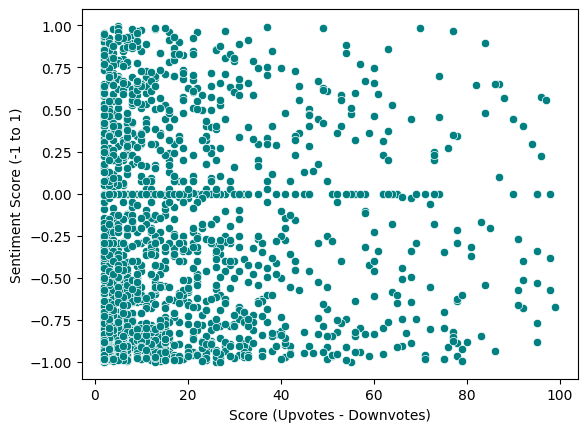

In [28]:
# Comparison of score and sentiment score when score between 0-100
# not including 1 as it's default value when creating a comment

df_score_sentiment_till_100 = df[(df['score'] > 1) & (df['score'] <=100)]

sns.scatterplot(data=df_score_sentiment_till_100, x='score', y='Sentiment_Score', color='teal')
plt.xlabel('Score (Upvotes - Downvotes)')
plt.ylabel('Sentiment Score (-1 to 1)')
plt.show()

In [29]:
# Checking correlation value between upvotes (score) and sentiment score
correlation_value = df['score'].corr(df['Sentiment_Score'])

print(f"The correlation value between 'score' and 'sentiment_score: {correlation_value:.4f}")

The correlation value between 'score' and 'sentiment_score: -0.0046


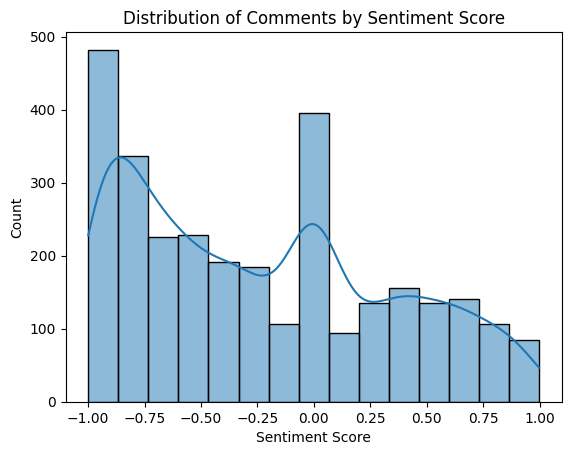

In [30]:
# Overall Distribution of sentiment score
sns.histplot(data=df, x='Sentiment_Score', kde=True)
plt.title('Distribution of Comments by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.show()


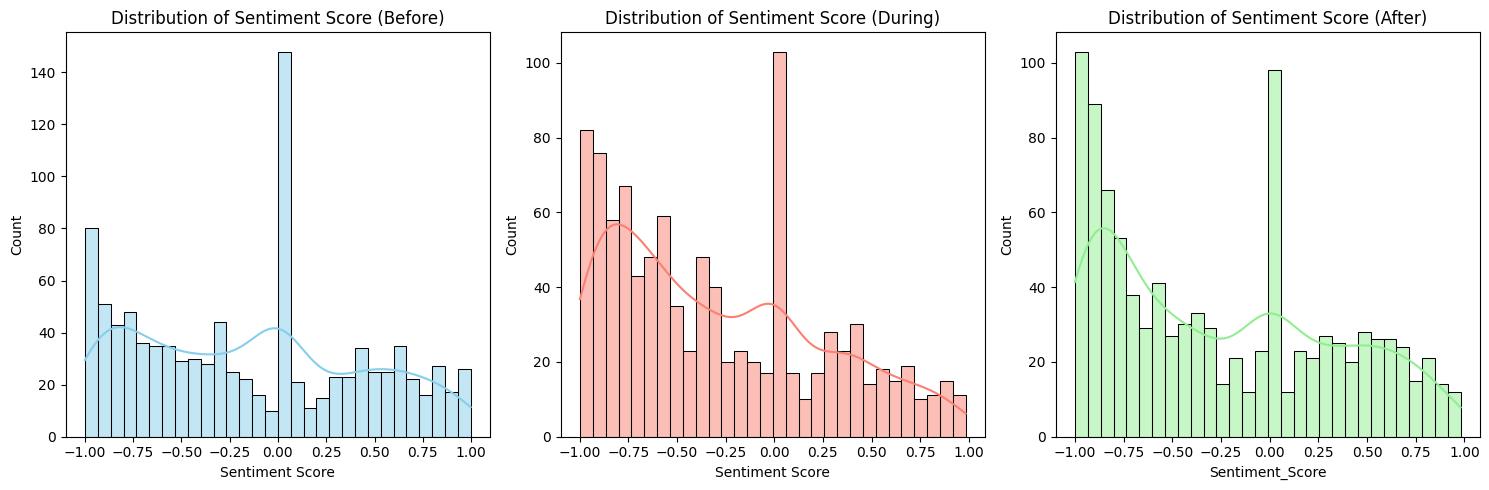

In [31]:
# Distribution of Commments By Time Period
df_before = df[df['period'] == 'Before']
df_during = df[df['period'] == 'During']
df_after = df[df['period'] == 'After']

# Create the figure and 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Distribution of DataFrame 1
sns.histplot(df_before['Sentiment_Score'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Sentiment Score (Before)')
axes[0].set_xlabel('Sentiment Score')


# Plot 2: Distribution of DataFrame 2
sns.histplot(df_during['Sentiment_Score'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Sentiment Score (During)')
axes[1].set_xlabel('Sentiment Score')


# Plot 3: Distribution of DataFrame 3
sns.histplot(df_after['Sentiment_Score'], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Distribution of Sentiment Score (After)')


# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()
plt.show()

C:\Users\nivya\AppData\Local\Temp\ipykernel_1716\801994461.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=period_negative_score, x='period', y='avg_sentiment_score', palette='YlGnBu', saturation=1,


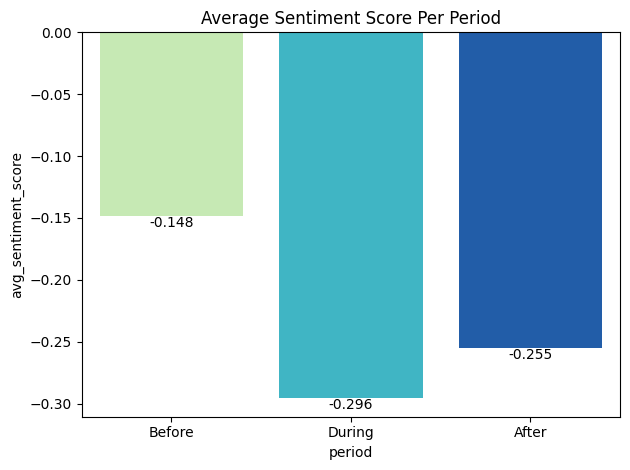

In [32]:
# Avg Sentiment Score before, during and after

# Calculate avg sentiment score per period
period_negative_score = df.groupby('period').agg(
    avg_sentiment_score = ('Sentiment_Score', 'mean')
).reset_index()

# Create Barplot
ax = sns.barplot(data=period_negative_score, x='period', y='avg_sentiment_score', palette='YlGnBu', saturation=1,
              order=['Before', 'During', 'After'])
# Add labels to each bar
for container in ax.containers:
  ax.bar_label(container, fmt='%.3f')
plt.title('Average Sentiment Score Per Period')
plt.tight_layout()
plt.show()

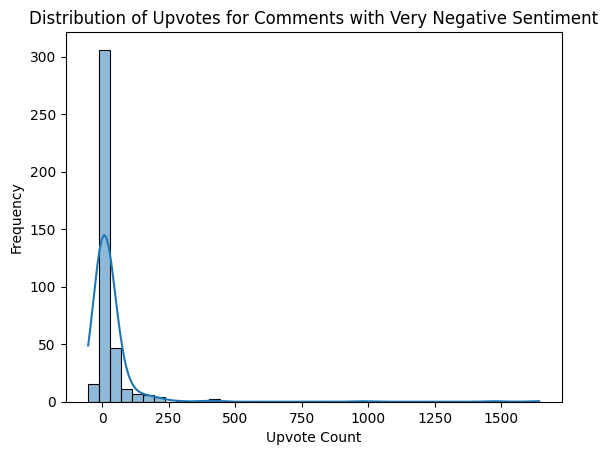

Total Comments: 3000
Very Negative Comments: 402
Proportion: 13.40%


In [33]:
# Distribution of Upvotes by Lowest Sentiment Score
df_negative_sentiment = df[(df['Sentiment_Score'] > -1) & (df['Sentiment_Score'] < -0.9)]
sns.histplot(data=df_negative_sentiment, x='score', kde=True)
plt.title('Distribution of Upvotes for Comments with Very Negative Sentiment')
plt.xlabel('Upvote Count')
plt.ylabel('Frequency')
plt.show()

# Proportion of Comments That Were Very Negative (-0.9 and below)
print(f"Total Comments: {df.shape[0]}\nVery Negative Comments: {df_negative_sentiment.shape[0]}\nProportion: {((df_negative_sentiment.shape[0]/df.shape[0])*100):.2f}%")


## THERE WERE MANY COMMENTS WITH EXTREMELY NEGATIVE SENTIMENT, THESE COMMENTS MOSTLY RECEIVED 1 UPVOTE INDICATING THAT THESE WERE COMMENTS MOST LIKELY LEFT BY TROLLS

In [34]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nivya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [35]:
# Keyword Trend Over Time

from nltk.corpus import stopwords
import re
from collections import Counter


# Load list of English stopwords ('the', 'a', 'is') and convert it to a set
STOPWORDS = set(stopwords.words('english'))

def get_top_keywords(series, top_n=10):
  '''
  Cleans text, removes stopwords, flattens all words, and returns the
  top N most common words.
  '''

  # Break text into words and clean
  # Handles punctuation and splitting comments into words
  all_words = series.astype(str).str.lower().str.findall(r'\b\w+\b').explode()

  additional_words = ['would', 'like', 'they', 'even', 'right', 'https', 'people', 'also', 'going', 'think', 'want']
  # Remove stopwords and filter out short tokens (like single letters)
  filtered_words = all_words[
      ~all_words.isin(STOPWORDS) &
      (all_words.str.len() > 3) &
      ~all_words.isin(additional_words)
  ]

  # Count frequencies
  word_counts = Counter(filtered_words.dropna().tolist())

  # Return the Top N
  return word_counts.most_common(top_n)


# Get top 10 keywords per period
df_top_10_words_before = pd.DataFrame(get_top_keywords(df_before['body']), columns=['Word', 'Count'])
df_top_10_words_during = pd.DataFrame(get_top_keywords(df_during['body']), columns=['Word', 'Count'])
df_top_10_words_after = pd.DataFrame(get_top_keywords(df_after['body']), columns=['Word', 'Count'])



In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 1 row and 3 columns
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Before October 7th', 'During October 7th', 'After October 7th')
)

# Plot 1: Before October 7th
fig.add_trace(
    go.Bar(
        x=df_top_10_words_before['Word'],
        y=df_top_10_words_before['Count'],
        marker=dict(color=df_top_10_words_before.index, colorscale='Phase'),
        showlegend=False
    ),
    row=1, col=1
)

# Plot 2: During October 7th
fig.add_trace(
    go.Bar(
        x=df_top_10_words_during['Word'],
        y=df_top_10_words_during['Count'],
        marker=dict(color=df_top_10_words_during.index, colorscale='Phase'),
        showlegend=False
    ),
    row=1, col=2
)

# Plot 3: After October 7th
fig.add_trace(
    go.Bar(
        x=df_top_10_words_after['Word'],
        y=df_top_10_words_after['Count'],
        marker=dict(color=df_top_10_words_after.index, colorscale='Phase'),
        showlegend=False
    ),
    row=1, col=3
)

# Update layout
fig.update_layout(
    title_text='Top 10 Keywords Over Time',
    title_font_size=16,
    height=500,
    width=1500,
    showlegend=False
)

# Update y-axis titles
fig.update_yaxes(title_text='Count')

fig.show()

### Roberta Pretrained Model

- This model accounts for the individual words that are part of a text but also recognizes the context related to other words.

- We're using hugginface's pretrained model as they are one of the leaders in this area (their library is 'transformers')

In [37]:
!pip install --upgrade transformers huggingface_hub

   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.0 MB 8.3 MB/s eta 0:00:02
   ---------------------------------------  11.8/12.0 MB 38.8 MB/s eta 0:00:01
   ---------------------------------------- 12.0/12.0 MB 35.6 MB/s  0:00:00
   ---------------------------------------- 0.0/566.1 kB ? eta -:--:--
   ---------------------------------------- 566.1/566.1 kB 19.0 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 52.4 MB/s  0:00:00

   ------ --------------------------------- 1/6 [fsspec]
   ------ --------------------------------- 1/6 [fsspec]
   -------------------- ------------------- 3/6 [huggingface_hub]
   -------------------- ------------------- 3/6 [huggingface_hub]
   -------------------- ------------------- 3/6 [huggingface_hub]
   -------------------- ------------------- 3/6 [huggingface_hub]
   -------------------- ---

In [38]:
from transformers import AutoTokenizer # Tokenize our text for machine learning purposes
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax # Apply to output to smooth out between 0 and 1

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [40]:
# Importing pre-trained model (trained on labeled tweets) with its weights
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


Compare VADER against Roberta

In [41]:
# VADER results on example
example = df['body'][2500]
print(example)
print(f"VADER results:\n{sia.polarity_scores(example)}")

the same allah that let israel be created and beat the muslim worlds ass over and over?
VADER results:
{'neg': 0.171, 'neu': 0.732, 'pos': 0.098, 'compound': -0.3612}


In [ ]:
# Run for Roberta Model

import numpy as np

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}

print(scores_dict)

{'roberta_neg': np.float32(0.8762319), 'roberta_neu': np.float32(0.12002205), 'roberta_pos': np.float32(0.0037461165)}


HAD TO CUT EXCESS TOKENS WITH TRUNCATION=TRUE (CUT THE TEXT)

In [42]:
# Run the Roberta Model on the entire dataset

# Define function to apply Roberta model to 'body' samples
def polarity_scores_roberta(example):
  '''
  Takes a sample (text), tokenizes it and runs it through the Roberta model,
  returns negative, neutral and positive scores
  '''
  encoded_text = tokenizer(
      example,
      return_tensors='pt',
      truncation=True,
      max_length=512)
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_list = [scores[0], scores[1], scores[2]]

  return scores_list

# Apply polarity_scores_roberta function to 'body' feature
new_columns = ['roberta_positive', 'roberta_neutral', 'roberta_negative']

for i, column in enumerate(new_columns):
  df[column] = df['body'].apply(lambda x: polarity_scores_roberta(x)[i])

df.head()

ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.

In [ ]:
# Plot distribution of sentiment scores across time periods

In [ ]:
# add a new column to out dataframe to see if it's before, during or after depending on the date range